In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import requests
import geopandas as gpd
from shapely.geometry import LineString
import numpy as np
import geodatasets

In [4]:
#load dataset
victims_coords = pd.read_csv('victims_coords.csv')

victims_coords

,name,age,park,state,year,notes,latitude,longitude
0,David Michael Burney,46,Bankhead National Forest,Alabama,2007,NaN,34.301863,-87.414071
1,James Taylor Wall,30,Bankhead National Forest,Alabama,2015,NaN,34.301863,-87.414071
2,Kevin Robert O’Keefe,36,Glacier Bay National Park,Alaska,1985,NaN,58.814175,-136.872094
3,Micheal LeMaitre,65,Mt. Marathon,Alaska,2012,NaN,61.280047,-147.224095
4,Sandra Gelber,61,Glacier Bay National Park,Alaska,2014,NaN,58.814175,-136.872094
...,...,...,...,...,...,...,...,...
258,Frederick Gabriel,56,Canyonlands National Park,Utha,2015,NaN,38.233259,-109.920663
259,Carroll Donald Parkins,78,Mt. Hood National Forest,Oregon,2023,NaN,45.209965,-121.723232
260,Caleb Josiah Howard,32,Mt. Hood National Forest,Oregon,2017,NaN,45.209965,-121.723232
261,Cassie Renee Sheetz,24,Monongahela National Forest,West Virginia,2021,NaN,38.331613,-80.310683


In [79]:
#looking at overall info in dataset
victims_coords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       263 non-null    object 
 1   age        263 non-null    object 
 2   park       263 non-null    object 
 3   state      263 non-null    object 
 4   year       263 non-null    int64  
 5   notes      20 non-null     object 
 6   latitude   263 non-null    float64
 7   longitude  263 non-null    float64
dtypes: float64(2), int64(1), object(5)
memory usage: 16.6+ KB


In [80]:
#checking data types
print("Original Data Types:")
print(victims_coords.dtypes)

Original Data Types:
name          object
age           object
park          object
state         object
year           int64
notes         object
latitude     float64
longitude    float64
dtype: object


In [81]:
victims_coords.describe()

,year,latitude,longitude
count,263.000000,263.000000,263.000000
mean,1996.281369,39.510005,-111.646526
std,23.065388,7.811641,16.408648
min,1909.000000,-32.033425,-155.729700
25%,1983.500000,36.174418,-121.025532
50%,2002.000000,37.839300,-118.146842
75%,2015.000000,44.038244,-109.315598
max,2024.000000,61.280047,-52.099130


In [82]:
#looking at layout
victims_coords.head(10)

,name,age,park,state,year,notes,latitude,longitude
0,David Michael Burney,46,Bankhead National Forest,Alabama,2007,NaN,34.301863,-87.414071
1,James Taylor Wall,30,Bankhead National Forest,Alabama,2015,NaN,34.301863,-87.414071
2,Kevin Robert O’Keefe,36,Glacier Bay National Park,Alaska,1985,NaN,58.814175,-136.872094
3,Micheal LeMaitre,65,Mt. Marathon,Alaska,2012,NaN,61.280047,-147.224095
4,Sandra Gelber,61,Glacier Bay National Park,Alaska,2014,NaN,58.814175,-136.872094
5,Sharon Buis,48,Glacier Bay National Park,Alaska,2014,body found,58.814175,-136.872094
6,Jonghyon Won,45,Grand Canyon,Arizona,2017,NaN,36.097743,-112.096762
7,Floyed E. Roberts III,52,Grand Canyon,Arizona,2016,NaN,36.097743,-112.096762
8,Morgan Heimer,22,Grand Canyon,Arizona,2015,NaN,36.097743,-112.096762
9,Drake Kramer,21,Grand Canyon,Arizona,2015,NaN,36.097743,-112.096762


In [83]:
#check for duplicates
victims_coords.duplicated().sum()

#print(victims_coords.duplicated().sum())

#remove duplicates
victims_coords = victims_coords.drop_duplicates()

#found 2 duplicate rows
victims_coords

,name,age,park,state,year,notes,latitude,longitude
0,David Michael Burney,46,Bankhead National Forest,Alabama,2007,NaN,34.301863,-87.414071
1,James Taylor Wall,30,Bankhead National Forest,Alabama,2015,NaN,34.301863,-87.414071
2,Kevin Robert O’Keefe,36,Glacier Bay National Park,Alaska,1985,NaN,58.814175,-136.872094
3,Micheal LeMaitre,65,Mt. Marathon,Alaska,2012,NaN,61.280047,-147.224095
4,Sandra Gelber,61,Glacier Bay National Park,Alaska,2014,NaN,58.814175,-136.872094
...,...,...,...,...,...,...,...,...
258,Frederick Gabriel,56,Canyonlands National Park,Utha,2015,NaN,38.233259,-109.920663
259,Carroll Donald Parkins,78,Mt. Hood National Forest,Oregon,2023,NaN,45.209965,-121.723232
260,Caleb Josiah Howard,32,Mt. Hood National Forest,Oregon,2017,NaN,45.209965,-121.723232
261,Cassie Renee Sheetz,24,Monongahela National Forest,West Virginia,2021,NaN,38.331613,-80.310683


In [84]:
#find missing values
missing_values = victims_coords.isnull()
missing_values

#Count missing values in each column
print(victims_coords.isna().sum())


name           0
age            0
park           0
state          0
year           0
notes        241
latitude       0
longitude      0
dtype: int64


In [85]:
#notes column missing 240 out of 261 rows of information so need to delete
victims_coords = victims_coords.drop(columns=['notes']) 

print(victims_coords.columns)

Index(['name', 'age', 'park', 'state', 'year', 'latitude', 'longitude'], dtype='object')


In [86]:
#manually found all the missing lat and long values and added them into dataset
#used google maps to find coordinates based on location information
missing_values

missing_values.isnull()

missing_values.any(axis=1)
missing_values[missing_values.any(axis=1)]  
 

,name,age,park,state,year,notes,latitude,longitude
0,False,False,False,False,False,True,False,False
1,False,False,False,False,False,True,False,False
2,False,False,False,False,False,True,False,False
3,False,False,False,False,False,True,False,False
4,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...
258,False,False,False,False,False,True,False,False
259,False,False,False,False,False,True,False,False
260,False,False,False,False,False,True,False,False
261,False,False,False,False,False,True,False,False


In [87]:
victims_coords.replace({'age': {'age unspecified': np.nan, '': np.nan}}, inplace=True)
print(victims_coords)




                        name  age                            park  \
0       David Michael Burney   46        Bankhead National Forest   
1          James Taylor Wall   30        Bankhead National Forest   
2       Kevin Robert O’Keefe   36       Glacier Bay National Park   
3           Micheal LeMaitre   65                    Mt. Marathon   
4              Sandra Gelber   61       Glacier Bay National Park   
..                       ...  ...                             ...   
258        Frederick Gabriel   56       Canyonlands National Park   
259   Carroll Donald Parkins   78        Mt. Hood National Forest   
260      Caleb Josiah Howard   32        Mt. Hood National Forest   
261      Cassie Renee Sheetz   24     Monongahela National Forest   
262  Raymond Aronld Saunders   44   Smoky Mountains National Park   

              state  year   latitude   longitude  
0           Alabama  2007  34.301863  -87.414071  
1           Alabama  2015  34.301863  -87.414071  
2            Alask

In [88]:
#set display option to see all rows
pd.set_option('display.max_rows', None)

#set back to default rows after finding missing values
pd.set_option('display.max_rows', 10)   


In [89]:
#count occurrences
location_counts = victims_coords['park'].value_counts()

#count most frequent location
most_frequent_location = location_counts.idxmax()

#get the most frequent location
print('Most Frequent Location:', most_frequent_location)

Most Frequent Location: Yosemite National Park


In [90]:
# Convert 'age' column to numeric, coercing errors to NaN
victims_coords['age'] = pd.to_numeric(victims_coords['age'], errors='coerce')

# youngest victim
youngest_age = victims_coords['age'].min()
print("The youngest age is:", youngest_age)

# oldest victim
oldest_age = victims_coords['age'].max()
print("The oldest age is:", oldest_age)

#average age of victims
average_age = victims_coords['age'].mean()
print("The average age is:", average_age)

The youngest age is: 2.0
The oldest age is: 90.0
The average age is: 37.90416666666667


In [91]:
#check total number of victims for each location
victims_coords['park'].value_counts()

park
Yosemite National Park                 39
Grand Canyon                            8
Great Smoky Mountains National Park     7
Plumas National Forest                  5
Yellowstone National Park               5
                                       ..
 Canyonlands National Park              1
 Mt. Hood National Forest               1
  Mt. Hood National Forest              1
 Monongahela National Forest            1
 Smoky Mountains National Park          1
Name: count, Length: 147, dtype: int64

In [92]:
# GPS coordinates that the Appalachian Mountains cover
lat_min, lat_max = 34.000000, 47.000000
lon_min, lon_max = -80.000000, -70.000000  # -80 is west, -70 is east

# Find total amount of missing people inside the boundaries of the Appalachian Mountains using GPS coordinates
appalachian_mtn_victims = victims_coords[
	victims_coords['latitude'].between(lat_min, lat_max) &
	victims_coords['longitude'].between(lon_min, lon_max)
]

appalachian_mtn_victims.shape[0]  # total number of victims in the Appalachian Mountains

11

In [93]:
#check top 10 years with most victims
victims_coords['year'].value_counts().head(10)


year
2015    16
2017    11
2006    11
2010    10
2019     9
1996     8
2016     8
1998     8
1978     7
2021     7
Name: count, dtype: int64

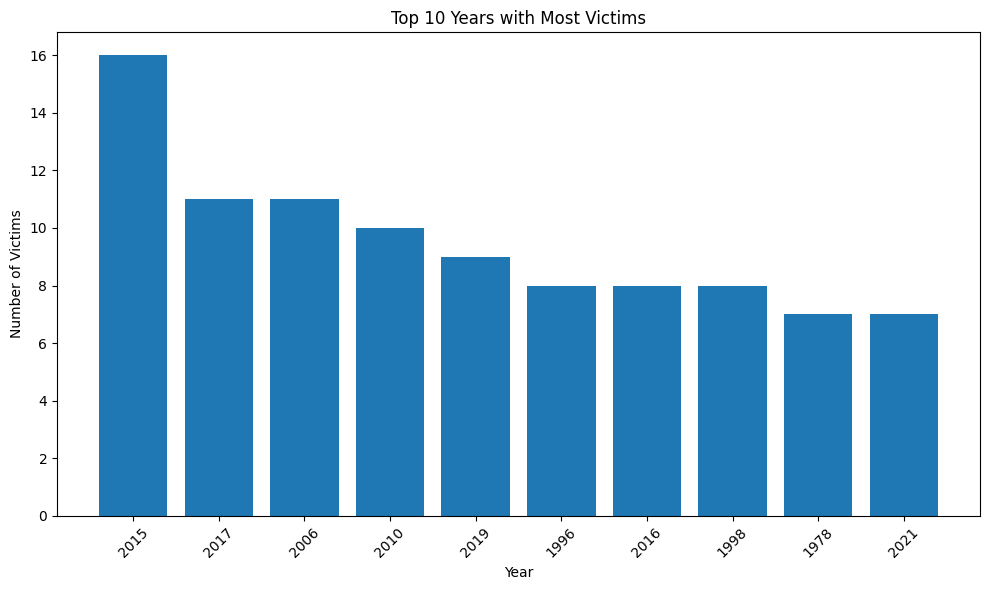

In [94]:
#visualize top 10 years with most victims
plt.figure(figsize=(10,6))
top_years = victims_coords['year'].value_counts().head(10)
plt.bar(top_years.index.astype(str), top_years.values)
plt.xlabel('Year')
plt.ylabel('Number of Victims')
plt.title('Top 10 Years with Most Victims')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

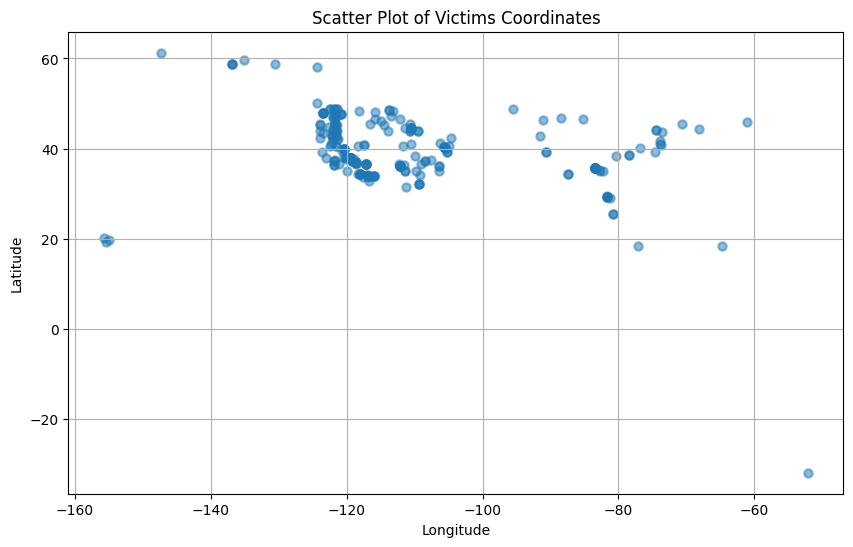

In [6]:
plt.figure(figsize=(10,6))
plt.scatter(victims_coords['longitude'], victims_coords['latitude'], linewidths=1.5, alpha=0.5)
plt.title('Scatter Plot of Victims Coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [7]:
#I chose a scatter plot to visualize the distribution of victims' coordinates because it effectively displays the geographical spread of incidents. Each point represents a victim's location, allowing us to identify clusters or patterns in specific areas. The scatter plot provides a clear visual representation of how victims are distributed across different longitudes and latitudes, making it easier to analyze spatial relationships and trends in the data...
#This type of plot is useful for identifying areas with higher concentrations of victims
 


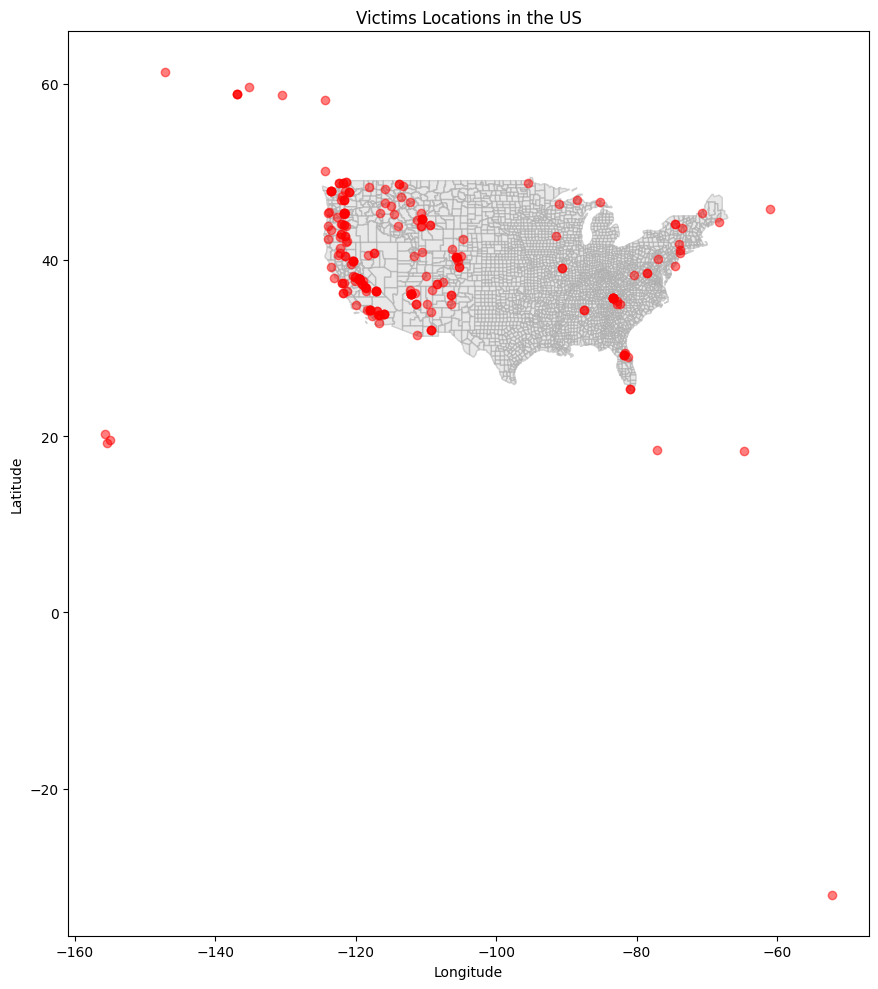

In [5]:
#create a scatter plot with a US map background using geopandas
# Load a base map of the US using geodatasets
us_states_fp = geodatasets.get_path("geoda.natregimes")
usa = gpd.read_file(us_states_fp)

#plotting the map
fig, ax = plt.subplots(figsize=(15,10))
usa.plot(ax=ax, color='lightgrey', edgecolor='darkgrey', alpha=0.5)
ax.scatter(victims_coords['longitude'], victims_coords['latitude'], color='red', alpha=0.5)
ax.set_title('Victims Locations in the US')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

In [ ]:
#I installed and used the geopandas library to create a scatter plot with a US map background.
#Like the previous scatter plot, this visualization effectively displays the geographical distribution of victims across the United States. By overlaying the victims' coordinates on a map of the US, it provides a clearer context for understanding where incidents are concentrated in relation to state boundaries and geographical features. This type of plot is particularly useful for identifying regional patterns and hotspots, making it easier to analyze spatial relationships and trends in the data on a national scale.
#By using the map background, you can start to see where the clusters of victims are located in relation to the states and regions of the US.
#You can now see there is a cluster of victims in the Appalachian Mountain region as well as some in the western US, near Grand Teton National Park in Wyoming.
# I chose red so that the points stand out against the light gray background. Also, because red is often associated with urgency and danger.